# Analysis of Borrower Reliability

## Introduction

### Objective
The objective of this project is to analyze whether a client's marital status and the number of children they have influence their ability to repay a loan on time. This analysis is conducted for the bank's credit department and aims to improve the accuracy of the credit scoring model—a system designed to evaluate a potential borrower's ability to repay loans.

### Background
The credit scoring model is an essential tool for financial institutions, helping them assess the risk associated with lending to clients. By incorporating insights from client data, the model can better predict loan repayment behavior, minimizing financial risks for the bank.

### Dataset Description
The dataset provided by the bank includes statistics on clients' solvency. It contains the following columns:

- `children`: Number of children in the family.
- `days_employed`: Total work experience in days.
- `dob_years`: Age of the client in years.
- `education`: Level of education.
- `education_id`: Identifier for education level.
- `family_status`: Marital status of the client.
- `family_status_id`: Identifier for marital status.
- `gender`: Gender of the client.
- `income_type`: Employment type.
- `debt`: Indicates if the client had overdue loan payments.
- `total_income`: Monthly income of the client.
- `purpose`: Purpose of the loan.

### Goal
The findings from this research will be used to refine the credit scoring model, ensuring it effectively incorporates key factors such as marital status and family size. This will help the bank make more informed lending decisions and better assess potential risks.


## 1. Dataset Overview

In [78]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns

In [2]:
if os.path.exists('data_debts.csv'):
    data = pd.read_csv('data_debts.csv')
    print("Data successfully loaded locally.")
else:
    data = pd.read_csv('https://raw.githubusercontent.com/bronetazik99/Practicum_projects/refs/heads/main/Project1_debtsProject_1/data_debts.csv')
    print("Local data not available. Data loaded from the web.")

Data successfully loaded locally.


In [3]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


The first issue we can see is that variable `days_employed` has negative numbers. This problem has to be solved.

Moreover,`education` has the same meaning, but is written differently due to variations in uppercase and lowercase letters

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21331 entries, 0 to 21524
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   children               21331 non-null  int64  
 1   days_employed          21331 non-null  float64
 2   dob_years              21331 non-null  int64  
 3   education              21331 non-null  object 
 4   education_id           21331 non-null  int64  
 5   family_status          21331 non-null  object 
 6   family_status_id       21331 non-null  int64  
 7   gender                 21331 non-null  object 
 8   income_type            21331 non-null  object 
 9   debt                   21331 non-null  int64  
 10  total_income           21331 non-null  int32  
 11  purpose                21331 non-null  object 
 12  total_income_category  21331 non-null  object 
 13  purpose_category       21331 non-null  object 
dtypes: float64(1), int32(1), int64(5), object(7)
memory usage: 

The dataset consists of **21,525 rows** and **12 columns**, providing information about loan applicants and their repayment behavior.

Variables `days_employed` and `total_income` have missing entries that require preprocessing.

## 2. Data Preparation

### 2.1 Handling missing values

In [5]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

The dataset contains **2,174 missing values** in the `days_employed` and `total_income` columns, which need to be handled during preprocessing to ensure accurate analysis. All other columns are complete and ready for further exploration.

The `total_income` column contains data on clients' income. The income amount is most influenced by the type of employment. Therefore, the missing values in this column should be filled with the **median value for each employment type** from the `income_type` column. 

For example, if a person with the employment type "employee" has a missing value in the `total_income` column, it should be filled with the median income of all records with the same employment type.

In [6]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

Let's change negative values for `days_employed` on positive:

In [7]:
data['days_employed'] = data['days_employed'].abs()

We will fill the missing values in the `days_employed` column with the **median values for each employment type** from the `income_type` column.

In [8]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

Check that we have no missing values:

In [9]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### 2.2. Handling abnormal values

Let's look at the median length of employment in days for each type of employment:

In [10]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

Check the `children` column:

In [11]:
data['children'].value_counts()

children
 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: count, dtype: int64

**-20** and **-1** are quite abnormal values for the number of children. We'll delete these rows:

In [12]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

In [13]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

### 2.3 Changing data type

We'll transform `total_income` from **float** type to **integer**:

In [14]:
data['total_income'] = data['total_income'].astype(int)

### 2.4 Handling duplicates

Check the `education` column for implicit duplicates:

In [15]:
data['education'].value_counts()

education
среднее                13667
высшее                  4698
СРЕДНЕЕ                  766
Среднее                  703
неоконченное высшее      665
ВЫСШЕЕ                   271
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: count, dtype: int64

This column contains identical values written differently due to variations in uppercase and lowercase letters. We will convert all values to lowercase for consistency.

In [16]:
data['education'] = data['education'].str.lower()

Check the number of duplicates and delete them if they exist:

In [17]:
data.duplicated().sum()

71

In [18]:
data = data.drop_duplicates()

### 2.5 Categorization of data

We will create a new column in the dataframe `data` called `total_income_category` with the following categories:

- **0–30,000**: `'E'`
- **30,001–50,000**: `'D'`
- **50,001–200,000**: `'C'`
- **200,001–1,000,000**: `'B'`
- **1,000,001 and above**: `'A'`

In [21]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass       

In [22]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

We will check the list of unique loan purposes from the `purpose` column.

In [23]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

We will create a function that categorizes the values in the `purpose` column into a new column called `purpose_category` with the following categories:

- `'операции с автомобилем'` (operations with cars)
- `'операции с недвижимостью'` (operations with real estate)
- `'проведение свадьбы'` (wedding arrangements)
- `'получение образования'` (education)

For example:
- If the `purpose` column contains a substring like `'на покупку автомобиля'` (for car purchase), the new column `purpose_category` will have the value `'операции с автомобилем'`.

In [24]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [25]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## 3. Exploratory Data Analysis (EDA)

### 3.1 Is there a relationship between the number of children and loan repayment?

In [47]:
child_debt_ratio = data.groupby('children').agg({'debt' : ['count', 'sum', 'mean']}).reset_index()
child_debt_ratio.columns = child_debt_ratio.columns.map('_'.join)
print(child_debt_ratio)

   children_  debt_count  debt_sum  debt_mean
0          0       14091      1063   0.075438
1          1        4808       444   0.092346
2          2        2052       194   0.094542
3          3         330        27   0.081818
4          4          41         4   0.097561
5          5           9         0   0.000000


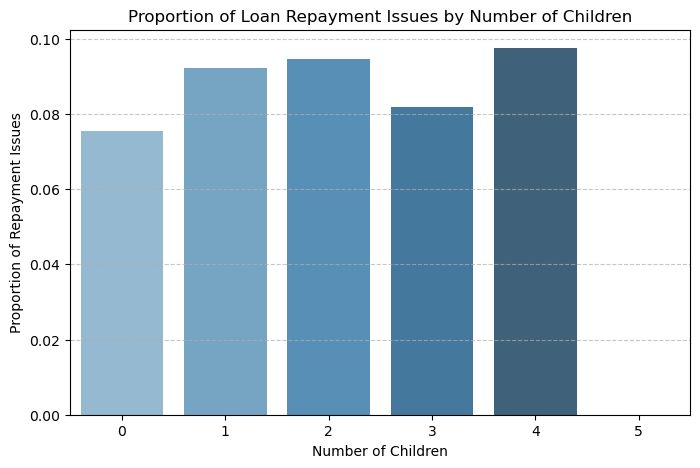

In [82]:
plt.figure(figsize=(8, 5))
sns.barplot(data=child_debt_ratio, x='children_', y='debt_mean', palette='Blues_d')
plt.title('Proportion of Loan Repayment Issues by Number of Children')
plt.xlabel('Number of Children')
plt.ylabel('Proportion of Repayment Issues')
plt.xticks(child_debt_ratio['children_'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

There is a slight increase in the proportion of loan repayment issues as the number of children increases, with a peak for families with 4 children. Families with 5 children exhibit no repayment issues, likely due to a small sample size. Further statistical analysis is required to confirm the significance of this trend.

**Hypotheses:**

**Null Hypothesis (H₀):**  
There is no relationship between the number of children and loan repayment issues. The proportion of clients with repayment issues is the same across all groups.

**Alternative Hypothesis (H₁):**  
There is a relationship between the number of children and loan repayment issues. The proportion of clients with repayment issues differs across groups.

In [67]:
# Filter out clients with 5 children
filtered_data = data[data['children'] != 5]

# Create the contingency table
contingency_table = pd.crosstab(filtered_data['children'], filtered_data['debt'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Statistic:", chi2)
print("p-value:", p)

if p < 0.05:
    print("\nConclusion: Reject the null hypothesis. There is a significant relationship between the number of children and loan repayment issues.")
else:
    print("\nConclusion: Fail to reject the null hypothesis. There is no significant relationship between the number of children and loan repayment issues.")


Chi-Square Test Statistic: 19.314281386265407
p-value: 0.0006817070498778774

Conclusion: Reject the null hypothesis. There is a significant relationship between the number of children and loan repayment issues.


We reject the null hypothesis. This means there is a statistically significant relationship between the number of children and loan repayment issues. The number of children a client has impacts their likelihood of repaying a loan on time.

### 3.2 Is there a relationship between marital status and loan repayment?

In [60]:
status_debt = data.groupby('family_status').agg({'debt': ['count', 'sum', 'mean']}).reset_index()
status_debt.columns = status_debt.columns.map('_'.join)
print(status_debt)

          family_status_  debt_count  debt_sum  debt_mean
0  Не женат / не замужем        2796       273   0.097639
1              в разводе        1189        84   0.070648
2         вдовец / вдова         951        63   0.066246
3       гражданский брак        4134       385   0.093130
4        женат / замужем       12261       927   0.075606


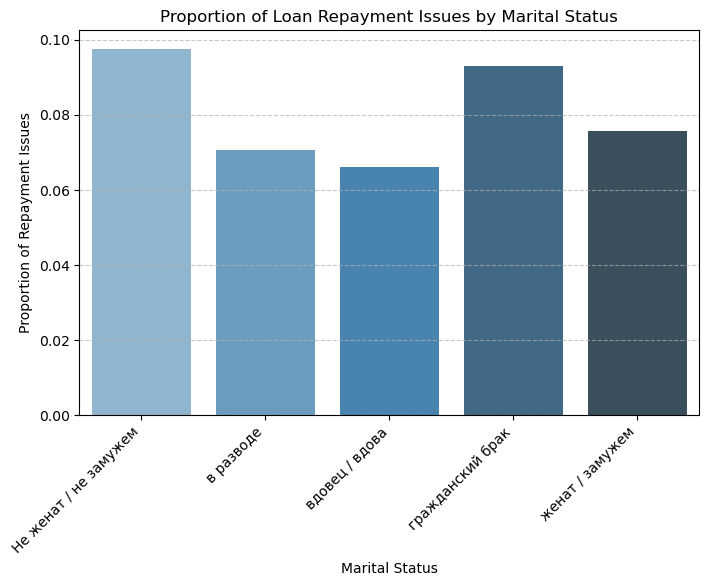

In [80]:
plt.figure(figsize=(8, 5))
sns.barplot(data=status_debt, x='family_status_', y='debt_mean', palette='Blues_d')
plt.title('Proportion of Loan Repayment Issues by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Repayment Issues')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. Clients who are **not married** (`Не женат / не замужем`) have the highest proportion of repayment issues, approximately 9.76%.
2. Clients who are **widowed** (`вдовец / вдова`) exhibit the lowest proportion of repayment issues, around 6.62%.
3. Clients in a **civil marriage** (`гражданский брак`) also show a relatively high proportion of repayment issues, about 9.31%.
4. Clients who are **married** (`женат / замужем`) and **divorced** (`в разводе`) show moderate proportions of repayment issues, 7.56% and 7.06%, respectively.

**Hypotheses:**

**Null Hypothesis (H₀):**  
There is no relationship between marital status and loan repayment issues. The proportions of repayment issues are the same across all marital status groups.

**Alternative Hypothesis (H₁):**  
There is a relationship between marital status and loan repayment issues. The proportions of repayment issues differ across marital status groups.


In [64]:
# Create a contingency table
contingency_table = pd.crosstab(data['family_status'], data['debt'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test Statistic:", chi2)
print("p-value:", p)

if p < 0.05:
    print("\nConclusion: Reject the null hypothesis. There is a significant relationship between marital status and loan repayment issues.")
else:
    print("\nConclusion: Fail to reject the null hypothesis. There is no significant relationship between marital status and loan repayment issues.")


Chi-Square Test Statistic: 27.784522630372297
p-value: 1.3792030784697729e-05

Conclusion: Reject the null hypothesis. There is a significant relationship between marital status and loan repayment issues.


We reject the null hypothesis. This indicates that there is a statistically significant relationship between marital status and loan repayment issues. Marital status plays a role in determining the likelihood of loan repayment.

### 3.3 Is there a relationship between income level and loan repayment?

In [68]:
income_debt = data.groupby('total_income_category').agg({'debt': ['count', 'sum', 'mean']}).reset_index()
income_debt.columns = income_debt.columns.map('_'.join)
print(income_debt)

  total_income_category_  debt_count  debt_sum  debt_mean
0                      A          25         2   0.080000
1                      B        5014       354   0.070602
2                      C       15921      1353   0.084982
3                      D         349        21   0.060172
4                      E          22         2   0.090909


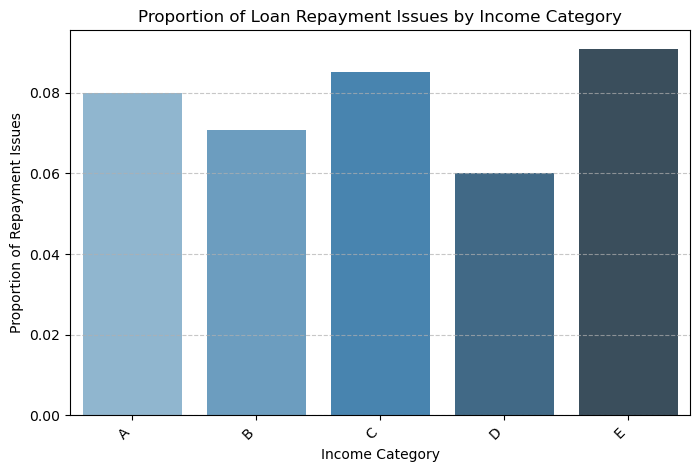

In [79]:
plt.figure(figsize=(8, 5))
sns.barplot(data=income_debt, x='total_income_category_', y='debt_mean', palette='Blues_d')
plt.title('Proportion of Loan Repayment Issues by Income Category')
plt.xlabel('Income Category')
plt.ylabel('Proportion of Repayment Issues')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The bar chart shows the proportion of loan repayment issues across different income categories:

1. **Group C** (Middle Income: 50,001–200,000) has high proportion of repayment issues (~8.5%).
2. **Group E** (Low Income: 0–30,000) has the highest proportion of repayment issues (~9%).
3. **Group D** (Lower-Middle Income: 30,001–50,000) has the lowest proportion of repayment issues (~6%).
4. **Group A** (High Income: 1,000,001+) and **Group B** (Upper-Middle Income: 200,001–1,000,000) show moderate proportions of repayment issues (~8%).

Further statistical testing is required to determine if these differences are significant.

**Hypotheses:**

**Null Hypothesis (H₀):**
There is no relationship between income level and loan repayment issues. The proportions of repayment issues are the same across all income groups.

**Alternative Hypothesis (H₁):**
There is a relationship between income level and loan repayment issues. The proportions of repayment issues differ across income groups.


In [72]:
# Create a contingency table
income_contingency_table = pd.crosstab(data['total_income_category'], data['debt'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(income_contingency_table)

print("Chi-Square Test Statistic:", chi2)
print("p-value:", p)

if p < 0.05:
    print("\nConclusion: Reject the null hypothesis. There is a significant relationship between income level and loan repayment issues.")
else:
    print("\nConclusion: Fail to reject the null hypothesis. There is no significant relationship between income level and loan repayment issues.")


Chi-Square Test Statistic: 12.697736475674613
p-value: 0.012851150768066123

Conclusion: Reject the null hypothesis. There is a significant relationship between income level and loan repayment issues.


We reject the null hypothesis. This means there is a statistically significant relationship between income level and loan repayment issues. Income level appears to influence the likelihood of loan repayment.

### 3.4 How do different loan purposes affect timely repayment?

In [73]:
purpose_debt = data.groupby('purpose_category').agg({'debt': ['count', 'sum', 'mean']}).reset_index()
purpose_debt.columns = purpose_debt.columns.map('_'.join)
print(purpose_debt)

          purpose_category_  debt_count  debt_sum  debt_mean
0    операции с автомобилем        4279       400   0.093480
1  операции с недвижимостью       10751       780   0.072551
2     получение образования        3988       369   0.092528
3        проведение свадьбы        2313       183   0.079118


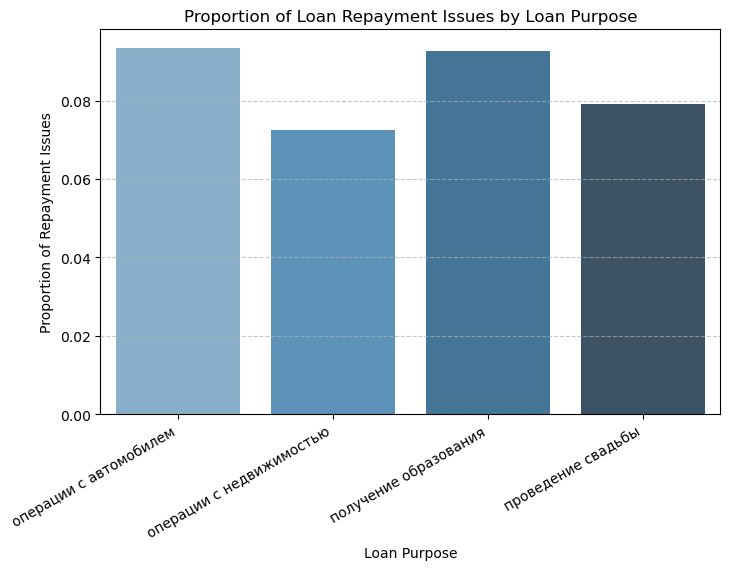

In [77]:
plt.figure(figsize=(8, 5))
sns.barplot(data=purpose_debt, x='purpose_category_', y='debt_mean', palette='Blues_d')
plt.title('Proportion of Loan Repayment Issues by Loan Purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Proportion of Repayment Issues')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

1. Loans for **real estate operations** show the lowest proportion of repayment issues (7.26%).
2. Loans for **cars** and **education** have the highest proportions of repayment issues (~9.3%).
3. Loans for **wedding arrangements** are in the mid-range, with a repayment issue proportion of 7.91%.

Further statistical testing is needed to determine if these differences are significant.

In [76]:
# Create a contingency table
purpose_contingency_table = pd.crosstab(data['purpose_category'], data['debt'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(purpose_contingency_table)

print("Chi-Square Test Statistic:", chi2)
print("p-value:", p)

if p < 0.05:
    print("\nConclusion: Reject the null hypothesis. There is a significant relationship between loan purpose and loan repayment issues.")
else:
    print("\nConclusion: Fail to reject the null hypothesis. There is no significant relationship between loan purpose and loan repayment issues.")


Chi-Square Test Statistic: 26.421595541475384
p-value: 7.782778835417843e-06

Conclusion: Reject the null hypothesis. There is a significant relationship between loan purpose and loan repayment issues.


We reject the null hypothesis. This indicates that there is a statistically significant relationship between loan purpose and loan repayment issues. Loan purpose has a measurable impact on the likelihood of timely repayment.

## Project Summary

The goal of this project was to analyze how various factors, such as marital status, the number of children, income levels, and loan purposes, affect loan repayment behavior. The insights gained from this analysis aim to assist in refining the bank's credit scoring model, improving its accuracy in assessing the risk of loan repayment issues.

**Was the Goal Achieved?**  
Yes, the goal was achieved. Using statistical analyses and visualizations, we identified significant relationships between these factors and loan repayment behavior.

---

1. **Exploratory Data Analysis**:
   - The dataset was examined for missing values and inconsistencies, and necessary preprocessing steps were applied.
   - Income levels and loan purposes were categorized into meaningful groups.

2. **Hypothesis Testing**:
   - Chi-Square tests were performed to assess the statistical significance of the relationships between:
     - **Marital Status** and Loan Repayment.
     - **Number of Children** and Loan Repayment.
     - **Income Level** and Loan Repayment.
     - **Loan Purpose** and Loan Repayment.

3. **Visualization**:
   - Bar charts were used to visualize the proportion of repayment issues across various categories (e.g., marital status, income levels, loan purposes).

---


1. **Marital Status**:
   - A statistically significant relationship was found.
   - Clients who are **not married** have the highest proportion of repayment issues, while **widowed clients** have the lowest.

2. **Number of Children**:
   - A statistically significant relationship was found.
   - Clients with **no children** have the lowest repayment issues, while repayment issues slightly increase with more children.

3. **Income Levels**:
   - A statistically significant relationship was found.
   - Clients in the **middle income group (50,001–200,000)** and **low income group (0–30,000)** have the highest repayment issues, while the **lower-middle income group (30,001–50,000)** has the lowest.

4. **Loan Purpose**:
   - A statistically significant relationship was found.
   - Loans for **real estate operations** have the lowest repayment issues, while loans for **cars** and **education** have the highest.

---


The insights derived from this analysis can be implemented as follows:
1. **Refinement of Credit Scoring Models**:
   - Incorporate factors like marital status, number of children, income level, and loan purpose into the scoring model to better predict repayment behavior.
   - Assign higher risk scores to loan applications for purposes or groups with higher repayment issues (e.g., car loans, clients with many children).

2. **Targeted Policies**:
   - Design targeted financial education programs for high-risk groups, such as unmarried clients or those taking loans for cars and education.
   - Adjust loan terms (e.g., interest rates, approval criteria) for high-risk categories to mitigate repayment issues.

3. **Enhanced Decision-Making**:
   - Enable loan officers to make more informed decisions by integrating these risk factors into their evaluations.

---

This project successfully identified key factors influencing loan repayment behavior and provided actionable insights to improve the bank's risk assessment and loan approval process. These findings can help the bank reduce loan defaults and optimize its credit policies.
